In [108]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [109]:
import cv2
import glob
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf

In [110]:
images = glob.glob("/content/drive/MyDrive/CS_499/new_dataset/**/*.jpg")
len(images)

6170

In [111]:
dataset = {}
for img in images:
  class_name = img.split('/')[-2]
  if class_name in dataset:
    dataset[class_name].append(img)
  else:
    dataset[class_name] = [img]

In [112]:
bin_n = 16
def hog(img):
    gx = cv2.Sobel(img, cv2.CV_32F, 1, 0)
    gy = cv2.Sobel(img, cv2.CV_32F, 0, 1)
    mag, ang = cv2.cartToPolar(gx, gy)
    bins = np.int32(bin_n*ang/(2*np.pi))
    bin_cells = bins[:10,:10], bins[10:,:10], bins[:10,10:], bins[10:,10:]
    mag_cells = mag[:10,:10], mag[10:,:10], mag[:10,10:], mag[10:,10:]
    hists = [np.bincount(b.ravel(), m.ravel(), bin_n) for b, m in zip(bin_cells, mag_cells)]
    hist = np.hstack(hists)
    return hist

In [130]:
hog_data = []
def convert_to_lab(image):
    lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    return lab_image

for class_name, img_list in tqdm(dataset.items(), desc="Processing images"):
    for img_path in img_list:
        img = np.array(Image.open(img_path))
        img_gray = np.mean(img, axis=-1)
        non_black_coords = np.column_stack(np.where(img_gray > 0))
        top_left = np.min(non_black_coords, axis=0)
        bottom_right = np.max(non_black_coords, axis=0)
        cropped_img = img[top_left[0]:bottom_right[0]+1, top_left[1]:bottom_right[1]+1, :]
        # hog_features = hog(cropped_img)
        lab_img = convert_to_lab(cropped_img)
        hog_features = hog(lab_img)
        # hog_features = hog(img)
        hog_data.append({'Class': class_name, 'HOG': hog_features})
df = pd.DataFrame(hog_data)

Processing images: 100%|██████████| 8/8 [00:56<00:00,  7.05s/it]


In [131]:
df.to_csv("df.csv")

In [132]:
df_hog_features = pd.DataFrame(df['HOG'].tolist(), columns=[f'HOG_{i}' for i in range(len(df['HOG'].iloc[0]))])
df = pd.concat([df, df_hog_features], axis=1)
df = df.drop(['HOG'], axis=1)

In [133]:
df

,Class,HOG_0,HOG_1,HOG_2,HOG_3,HOG_4,HOG_5,HOG_6,HOG_7,HOG_8,...,HOG_54,HOG_55,HOG_56,HOG_57,HOG_58,HOG_59,HOG_60,HOG_61,HOG_62,HOG_63
0,inhouse_unbaked,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,68171.408486,50995.178607,49846.292805,54544.961134,56974.795029,67681.553805,77300.719139,59494.280936,59206.347106,55965.857212
1,inhouse_unbaked,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,85653.172978,72041.922197,95298.416260,95312.141472,94156.448717,105877.770765,127395.953181,93530.219220,81444.600991,56112.058450
2,inhouse_unbaked,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,33796.551352,35175.467116,40483.341480,47509.183710,43349.957510,36908.825449,37607.046148,30031.424428,30328.653205,26671.920555
3,inhouse_unbaked,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,145069.496700,154224.238439,199113.574641,173884.764389,124403.845931,129003.473228,154102.918413,122315.785306,145239.214259,124894.088116
4,inhouse_unbaked,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,75299.250354,88607.862729,87792.734811,64315.673674,46142.733117,52041.455912,53954.708265,50569.091691,80920.596946,83016.136410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6165,commercial_deep_over,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,79188.551429,69849.246033,83548.045569,98126.391910,103247.634827,117336.601317,117574.150899,83182.106462,84277.717407,70391.513155
6166,commercial_deep_over,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,73057.535756,73706.509739,82190.402162,85254.856892,77599.943298,78311.235011,73131.614001,61678.007286,67704.196659,59912.981743
6167,commercial_deep_over,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,143711.344295,144683.734758,161908.990471,129033.759362,97251.256582,96231.904353,113085.131811,112791.043989,138457.787437,153758.359450
6168,commercial_deep_over,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,235229.837874,196383.176354,154082.202283,103932.283746,76020.319074,85706.597624,119676.991878,149439.277156,233974.911540,230908.304843


In [134]:
le = LabelEncoder()
df['Class'] = le.fit_transform(df['Class'])

In [135]:
X = df.drop(['Class'], axis=1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Logistic Regression

In [136]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
logistic_regression = LogisticRegression(max_iter=1000)
logistic_regression.fit(X_train_scaled, y_train)
y_pred = logistic_regression.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.36223662884927066


## SVM

In [137]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
svm_classifier = SVC(kernel='linear', C=12.0)
svm_classifier.fit(X_train_scaled, y_train)
y_pred = svm_classifier.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.3573743922204214


## Random Forest

In [140]:
random_forest = RandomForestClassifier(n_estimators=200, random_state=42)
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.37925445705024313


## KNN

In [141]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
knn_classifier = KNeighborsClassifier(n_neighbors=32)
knn_classifier.fit(X_train_scaled, y_train)
y_pred = knn_classifier.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.31685575364667745


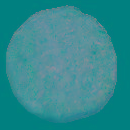

In [143]:
Image.fromarray(lab_img)